<a href="https://colab.research.google.com/github/dvircohen0/projects/blob/main/audio_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

download the test part of the dataset and use it for training

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_aac.zip
!unzip '/content/vox2_test_aac.zip'

In [ ]:
!pip install split-folders
!pip install unsilence
!pip install --upgrade gupload

In [3]:
from tqdm.notebook import tqdm
import librosa
import librosa.display
import os
import pylab
from pathlib import Path, PurePath
import numpy as np
import pandas as pd
from datetime import datetime
import glob
import random
from PIL import Image
import splitfolders 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


from google.colab import files
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')


Mounted at /content/drive


create folders for spectograms

In [18]:
data_folder ='/content/aac'
ids = os.listdir(data_folder)

spectogram_folder = '/content/spectogram'

if not os.path.exists(spectogram_folder):
    os.makedirs(spectogram_folder)

for id_ in ids:
  if not os.path.exists(os.path.join(spectogram_folder,id_)):
    os.makedirs(os.path.join(spectogram_folder,id_))

file_list = glob.glob(data_folder+'/*/*/*.m4a')

function that reads audio file nd save the mel spctogram of the file

In [37]:
def audio_to_spectogam(path):
        # read the file
        y, sr = librosa.load(path, mono=True)
        # calculate mel spectogram
        mel=librosa.feature.melspectrogram(y=y, sr=sr)
        # define 160x160 pixels image
        pylab.figure(figsize=(160/100,160/100), dpi=100)
        pylab.axis('off') 
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) 
        log_power = librosa.power_to_db(mel, ref=np.max)
        librosa.display.specshow(log_power)
        # define the file name of the spectogram
        filename=Path(path).stem
        id_=PurePath(path).parts[3]
        id_2=PurePath(path).parts[4]
        folder_path = os.path.join(spectogram_folder ,id_)
        pylab.savefig(os.path.join(folder_path,id_2 +filename) + ".jpg")
        pylab.close()

removing silence and apply spectogram function (i didnt do all the files, because it takes a LOT of time and the kernel died)

In [ ]:
for file in tqdm(file_list, desc="..."):
  # use unsilence library for silence removal
    os.system("unsilence [{}] [{}]".format(file,file))
    audio_to_spectogam(file)

# save the spectogram in the drive
!zip -r /content/spectograms.zip /content/spectogram
!cp -r /content/spectograms.zip /content/drive/MyDrive/voxceleb
files.download("/content/spectograms.zip")

Display sampled spectograms

In [ ]:
!unzip /content/drive/MyDrive/voxceleb/spectograms.zip

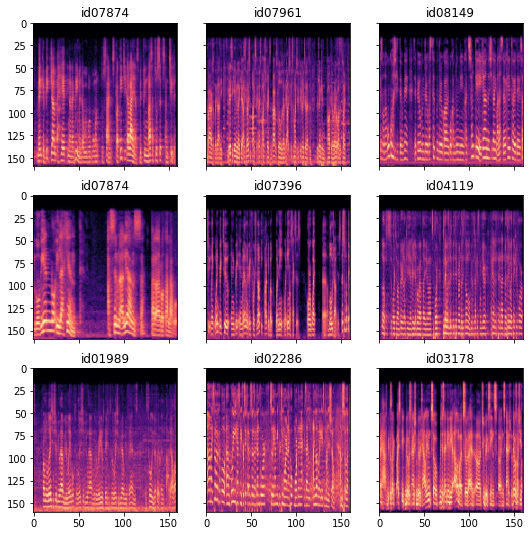

In [33]:
spectogram_list = glob.glob("/content/content/spectogram/*/*.jpg")
sampled_images_path=random.sample(spectogram_list, 9)

sampled_images=[]
for image in sampled_images_path:
  sampled_images.append(mpimg.imread(image))

fig = plt.figure(1, (9, 9))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.4)

for i,axes in enumerate(grid):
    axes.set_title(PurePath(sampled_images_path[i]).parts[4], fontdict=None, loc='center', color = "k")
    axes.imshow(sampled_images[i])

plt.show()

split the spectogram folder into train test validation folders

In [40]:
#split the combined folder into test, train, validation folders
splitfolders.ratio("/content/spectogram", output="./dataset", seed=1337, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 1444 files [00:00, 6519.08 files/s]


**Build a numeric features Dataset for DNN**

In [92]:
# build CSV for dataset with folder path and labels

labels=[PurePath(path).parts[3] for path in glob.glob(data_folder+'/*/*/*.m4a')]

dataset_df = pd.DataFrame(
    {'file': glob.glob(data_folder+'/*/*/*.m4a'),
     'id': labels })

dataset_df.to_csv('Dataset.csv')

In [60]:
dataset_df.head()

,file,id
0,/content/aac/id07874/Li3vQdN8yzg/00009.m4a,id07874
1,/content/aac/id07874/Li3vQdN8yzg/00036.m4a,id07874
2,/content/aac/id07874/Li3vQdN8yzg/00041.m4a,id07874
3,/content/aac/id07874/Li3vQdN8yzg/00043.m4a,id07874
4,/content/aac/id07874/Li3vQdN8yzg/00024.m4a,id07874


Getting fatures from Audio file:
mffc, chromagram, melspectrogram,tonal centroid features.

In [158]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):


    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(files.file, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    # We add also the classes of each file as a label at the end
    label = files.id

    return mfccs, chroma, mel, contrast, tonnetz, label

In [97]:
from tqdm.auto import tqdm
tqdm.pandas(desc="...")

apply the function on all the audio files, save file in tge drive every 500 files. the kernel died after 16500 files

In [ ]:
dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)

#features_label = dataset_df.swifter.apply(extract_features, axis=1)
features_label=[]
for row in dataset_df.itertuples():
  features_label.append(extract_features(row))
  if row.Index % 500 ==0:
      print(str(row.Index) + " saving checkpoint...")
      np.save('features_label_in1', features_label)
      !cp -r /content/features_label_in1.npy /content/drive/MyDrive/voxceleb


np.save('features_label', features_label)
!cp -r /content/features_label.npy /content/drive/MyDrive/voxceleb
#files.download("/content/features_label.npy")



0 saving checkpoint...
500 saving checkpoint...
1000 saving checkpoint...
1500 saving checkpoint...
2000 saving checkpoint...
2500 saving checkpoint...
3000 saving checkpoint...
3500 saving checkpoint...
4000 saving checkpoint...
4500 saving checkpoint...
5000 saving checkpoint...
5500 saving checkpoint...
6000 saving checkpoint...
6500 saving checkpoint...
7000 saving checkpoint...
7500 saving checkpoint...
8000 saving checkpoint...
8500 saving checkpoint...
9000 saving checkpoint...
9500 saving checkpoint...
10000 saving checkpoint...
10500 saving checkpoint...
11000 saving checkpoint...
11500 saving checkpoint...
12000 saving checkpoint...
12500 saving checkpoint...
13000 saving checkpoint...
13500 saving checkpoint...
14000 saving checkpoint...
14500 saving checkpoint...
15000 saving checkpoint...
15500 saving checkpoint...
16000 saving checkpoint...
16500 saving checkpoint...


In [168]:
features_label = np.load('/content/features_label_in.npy', allow_pickle=True)